<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import os

import numpy as np
from scipy.stats import poisson
from scipy.stats import norm

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

import seaborn as sns
sns.set_context('notebook', font_scale=1.5)
sns.set_style('darkgrid', rc={'ytick.left':True, 'ytick.direction':'in',
                              'xtick.bottom':True, 'xtick.direction':'in'})

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

## Подготовка

In [2]:
def get_data(filename):
    
    """
    Reads the data from the given path.
    """

    pth1 = f'/datasets/{filename}'
    pth2 = f'data/{filename}'

    if os.path.exists(pth1):
        df = pd.read_csv(pth1, parse_dates=['datetime'], index_col='datetime')
        print(f'Reading {pth1}...')
    elif os.path.exists(pth2):
        df = pd.read_csv(pth2, parse_dates=['datetime'], index_col='datetime')
        print(f'Reading {pth2}...')
    else:
        print('Check the file path')

    return df

In [3]:
file_name = 'taxi.csv'
df = get_data(file_name)
df.sort_index(inplace=True)

df.head()

Reading data/taxi.csv...


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


## Анализ

In [5]:
np.unique(np.diff(df.index))[0].astype('timedelta64[m]')

numpy.timedelta64(10,'m')

Статистика собрана для одинаковых интервалов (10 минут).

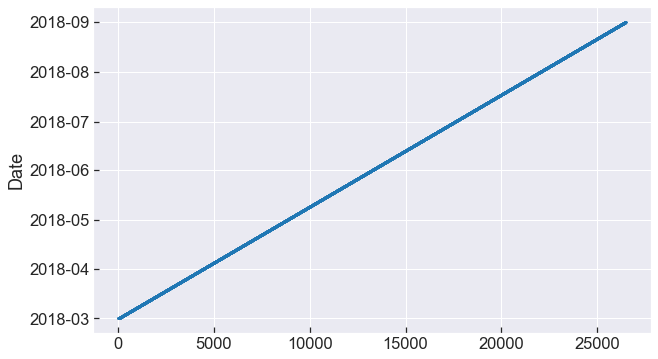

In [6]:
plt.scatter(np.arange(len(df)), df.index, s=1)

plt.ylabel('Date')

plt.show()

Данные представлены с марта по сентябрь 2018 года и отсортированы по возрастанию даты.

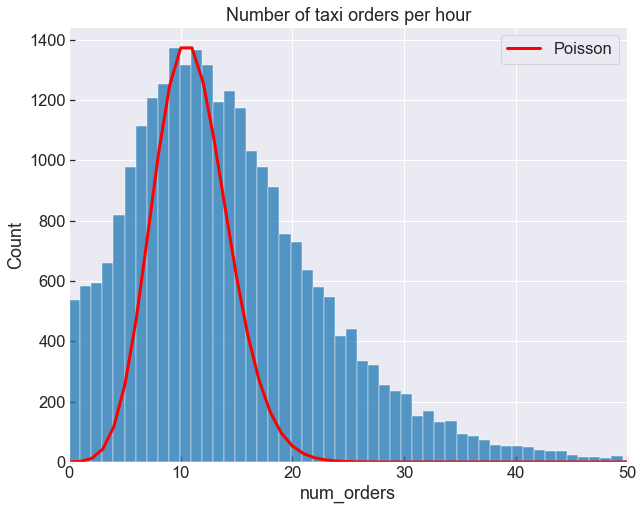

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.histplot(df['num_orders'], bins=120, ax=ax)

k = np.arange(60)
# Нормировку и среднее подбираю на глаз
poisson_k = 1.15e4 * poisson.pmf(k, 11)

ax.plot(k, poisson_k, 'r', label='Poisson', lw=3)
ax.legend()

ax.set_xlim(0, 50)
ax.set_title('Number of taxi orders per hour')

plt.show()

Откуда такие отклонения от Пуассона? Кажется, что это должен быть классический пример распределения. Может быть $\mu$ изменяется во времени и данные получится описать совокупностью Пуассоновских распределений?

In [8]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [9]:
df.isna().sum()

num_orders    0
dtype: int64

Медианное значение $-$ 14 заказов за 10 минут.

### Ресемплирование

In [10]:
df = df.resample('1H').sum()

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


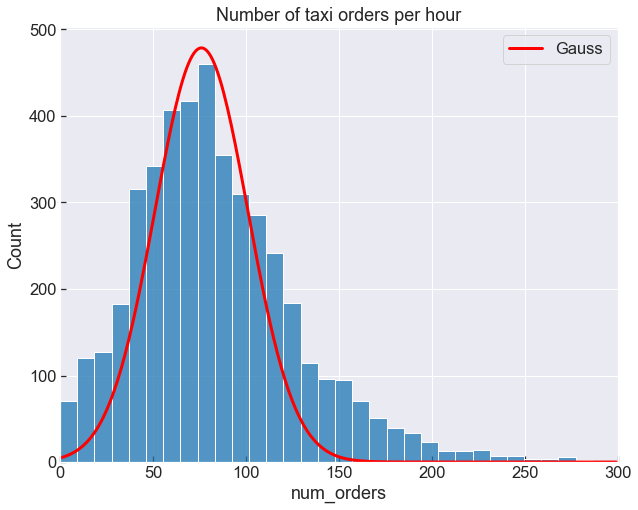

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.histplot(df['num_orders'], bins=50, ax=ax)

k = np.arange(300)
# Нормировку и среднее подбираю на глаз
poisson_k = 3e4 * norm.pdf(k, loc=df['num_orders'].mean() * .9, scale=25)

ax.plot(k, poisson_k, 'r', label='Gauss', lw=3)
ax.legend()

ax.set_xlim(0, 300)
ax.set_title('Number of taxi orders per hour')

plt.show()

После ресемплирования распределения стало больше походить на нормальное.

### Создание признаков

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    # data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    # Отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # Скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(df, 24, 48)

In [13]:
df

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,170.895833
2018-08-31 20:00:00,154,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,170.208333
2018-08-31 21:00:00,159,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,169.437500


## Обучение

### Линейная регрессия

In [14]:
train, test = train_test_split(df, shuffle=False,
                               test_size=.1, random_state=42)

train = train.dropna()

train

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,3,3,5,72.0,119.0,101.0,93.0,49.0,89.0,...,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,59.791667
2018-03-03 01:00:00,108,3,3,5,163.0,72.0,119.0,101.0,93.0,49.0,...,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,60.604167
2018-03-03 02:00:00,25,3,3,5,108.0,163.0,72.0,119.0,101.0,93.0,...,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,61.083333
2018-03-03 03:00:00,64,3,3,5,25.0,108.0,163.0,72.0,119.0,101.0,...,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,60.125000
2018-03-03 04:00:00,44,3,3,5,64.0,25.0,108.0,163.0,72.0,119.0,...,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,60.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,137,8,13,0,91.0,39.0,66.0,83.0,143.0,168.0,...,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,108.0,119.416667
2018-08-13 10:00:00,156,8,13,0,137.0,91.0,39.0,66.0,83.0,143.0,...,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,119.770833
2018-08-13 11:00:00,144,8,13,0,156.0,137.0,91.0,39.0,66.0,83.0,...,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,120.104167


In [15]:
train.index.dayofweek.unique()

Int64Index([5, 6, 0, 1, 2, 3, 4], dtype='int64', name='datetime')

In [16]:
X_test, X_train = test.drop(columns='num_orders'), train.drop(columns='num_orders')
y_test, y_train = test['num_orders'], train['num_orders']

# Scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

lin_test_predictions = lin_model.predict(X_test)
lin_train_predictions = lin_model.predict(X_train)

### LGBM

In [18]:
lgbm_model = LGBMRegressor(random_state=42, metric='rmse')

In [19]:
%%time
lgbm_model.fit(X_train, y_train)
lgbm_predictions = lgbm_model.predict(X_test)

lgbm_rmse = mse(y_test, lgbm_predictions) ** 0.5

print(f'LightGBM RMSE: {lgbm_rmse:.0f}')

LightGBM RMSE: 43
CPU times: user 1.11 s, sys: 221 ms, total: 1.33 s
Wall time: 210 ms


In [20]:
np.arange(100, 500, 100)

array([100, 200, 300, 400])

In [21]:
param_grid = {
    'num_leaves': np.arange(50, 300, 10),
    'min_data_in_leaf': np.arange(100, 1100, 100)
    }

random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=50,
    random_state=42
)

random_search_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START min_data_in_leaf=600, num_leaves=220.......................
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[CV 1/5; 1/10] END min_data_in_leaf=600, num_leaves=220;, score=-22.429 total time=   0.1s
[CV 2/5; 1/10] START min_data_in_leaf=600, num_leaves=220.......................
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[CV 2/5; 1/10] END min_data_in_leaf=600, num_leaves=220;, score=-23.574 total time=   0.0s
[CV 3/5; 1/10] START min_data_in_leaf=600, num_leaves=220.......................
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[CV 3/5; 1/10] END min_data_in_leaf=600, num_leaves=220;, score=-24.364 total time=   0.0s
[CV 4/5; 1/10] START min_data_in_leaf=600, num_leav

RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(metric='rmse', random_state=42),
                   param_distributions={'min_data_in_leaf': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
                                        'num_leaves': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290])},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=50)

In [22]:
-random_search_lgbm.best_score_

24.125203870467594

In [23]:
random_search_lgbm.best_params_

{'num_leaves': 110, 'min_data_in_leaf': 100}

In [24]:
lgbm_train_predictions = random_search_lgbm.predict(X_train)
lgbm_test_predictions = random_search_lgbm.predict(X_test)

print(f"RMSE обучающей выборки: {mse(y_train, lgbm_train_predictions) ** .5:.1f}")
print(f"RMSE тестовой выборки:  {mse(y_test, lgbm_test_predictions) ** .5:.1f}")

RMSE обучающей выборки: 15.4
RMSE тестовой выборки:  44.1


## Тестирование

In [25]:
lin_test_predictions = lin_model.predict(X_test)
lin_train_predictions = lin_model.predict(X_train)

In [26]:
print(f"RMSE обучающей выборки: {mse(y_train, lin_train_predictions) ** .5:.1f}")
print(f"RMSE тестовой выборки:  {mse(y_test, lin_test_predictions) ** .5:.1f}")

RMSE обучающей выборки: 25.8
RMSE тестовой выборки:  47.2


lag 0

RMSE обучающей выборки: 30.8

RMSE тестовой выборки:  52.9

lag 3

RMSE обучающей выборки: 30.6

RMSE тестовой выборки:  52.5

lag 5

RMSE обучающей выборки: 30.5

RMSE тестовой выборки:  52.8

lag 10

RMSE обучающей выборки: 30.2

RMSE тестовой выборки:  53.6

lag 20

RMSE обучающей выборки: 29.2

RMSE тестовой выборки:  55.2

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48